In [1]:
from aaa.geometry.descriptors.descriptor import Descriptor
from aaa.geometry.descriptors.descriptor3d import Descriptor3D
import nibabel as nib
import numpy as np
import nibabel as nib
import glob
from scipy.spatial import distance
import torch
import matplotlib.pyplot as plt
from tifffile import imsave
from scipy.interpolate import CubicSpline
from aaa.models.my_unet import my_unet
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
from aaa.geometry.enum import Classes
import random

from vtk import vtkXMLPolyDataWriter

import math

from typing import Callable
from aaa.utils import torch_float, torch_long, io

from scipy.signal import savgol_filter

import os
from scipy.spatial import KDTree
from tqdm import tqdm
import gc
from aaa.utils import io as misc
import imageio
from sklearn.manifold import Isomap
from aaa.models.unet3d_sm import Unet3dSm
from frechetdist import frdist
import torchvision.transforms as transforms
import imageio
from scipy import ndimage
from sklearn.decomposition import PCA
from vtk.util import numpy_support
import vtk
from scipy.spatial.distance import cdist

DIR = './'

/home/kirill/library/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def euclidean(p: np.ndarray, q: np.ndarray) -> float:
    d = p - q
    return math.sqrt(np.dot(d, d))
def chamfer_distance(arr1, arr2):
    distance_1_to_2 = 0
    distance_2_to_1 = 0

    points1 = arr1
    points2 = arr2

    for p1 in points1:
        distances = np.sqrt(np.sum((points2 - p1)**2, axis=1))
        min_distance = np.min(distances)
        distance_1_to_2 += min_distance

    for p2 in points2:
        distances = np.sqrt(np.sum((points1 - p2)**2, axis=1))
        min_distance = np.min(distances)
        distance_2_to_1 += min_distance

    return (distance_1_to_2 + distance_2_to_1) / (len(arr1) + len(arr2))
def linear_frechet(p: np.ndarray, q: np.ndarray, dist_func: Callable[[np.ndarray, np.ndarray], float]) -> float:
    n_p = p.shape[0]
    n_q = q.shape[0]
    ca = np.zeros((n_p, n_q), dtype=np.float64)

    for i in range(n_p):
        for j in range(n_q):
            d = dist_func(p[i], q[j])

            if i > 0 and j > 0:
                ca[i, j] = max(min(ca[i - 1, j],
                                   ca[i - 1, j - 1],
                                   ca[i, j - 1]), d)
            elif i > 0 and j == 0:
                ca[i, j] = max(ca[i - 1, 0], d)
            elif i == 0 and j > 0:
                ca[i, j] = max(ca[0, j - 1], d)
            else:
                ca[i, j] = d
    return ca[n_p - 1, n_q - 1]
def divide(bif_arr):
  
    left_bif = []
    right_bif = []
    for i in range(0, len(bif_arr), 2):
        if bif_arr[i][1] < bif_arr[i+1][1]:
            left_bif.append(bif_arr[i])
            right_bif.append(bif_arr[i+1])
        else:
            left_bif.append(bif_arr[i+1])
            right_bif.append(bif_arr[i])
    return np.array(left_bif), np.array(right_bif)
def smooth(curve, window_size):
    y_values = curve[:,1]
    x_values = curve[:,0]
    polynomial_order = 2

    smoothed_y = savgol_filter(y_values, window_size, polynomial_order)
    
    smoothed_curve = np.column_stack((x_values, smoothed_y))
    return smoothed_curve

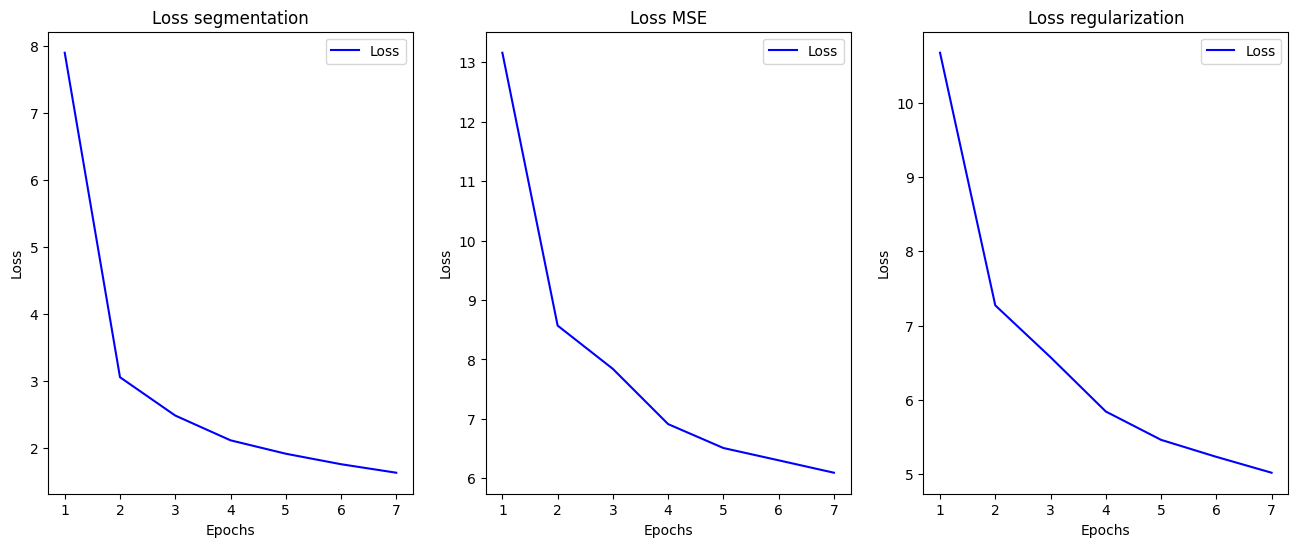

In [3]:
loss_mask = np.load(DIR + 'loss_mask.npy')
loss_mse = np.load(DIR + 'loss_mse.npy')
loss_reg = np.load(DIR + 'loss_reg.npy')


epochs = range(1, len(loss_mask) + 1)
plt.figure(figsize=(16, 6))

plt.subplot(131)

plt.plot(epochs, loss_mask, 'b', label='Loss')
plt.title('Loss segmentation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(132)
plt.plot(epochs, loss_mse, 'b', label='Loss')
plt.title('Loss MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(133)
plt.plot(epochs, loss_reg, 'b', label='Loss')
plt.title('Loss regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [20]:
val_frechet_field = []
val_chamfer_field = []
epochs = 8
instances = 1
for epoch in tqdm(range(epochs)):
    frechet = []
    chamfer = []
    frechet_bif = []
    frechet_single = []
    chamfer_bif = []
    chamfer_single = []
    for j in range(instances):
        print(j)
        prob_attraction = np.load(DIR+ f'/testtraining/save_pred_attractions{epoch}.npz')['data'][j]
        prob_masks = np.load(DIR+ f'/testtraining/save_pred_masks{epoch}.npz')['data'][j]
        attraction_fields = np.load(DIR+ f'/testtraining/save_attractions{epoch}.npz')['data'][j]
        pred_attraction_field =np.moveaxis(prob_attraction,0, -1)
        pred_centerline = np.zeros(pred_attraction_field.shape[:-1])
        pred_indices = []

        for z in tqdm(range(pred_attraction_field.shape[0])):
            for x in range(pred_attraction_field.shape[1]):
                for y in range(pred_attraction_field.shape[2]):
                    pred_indices.append(np.round(np.add([z, x, y], pred_attraction_field[z, x, y])))
        pred_indices = np.array(pred_indices).astype(int)

        for index in tqdm(pred_indices):
            try:
                pred_centerline[index[0], index[1], index[2]] +=1
            except:
                continue

        pred_mask = prob_masks.argmax(axis = 0)
        pred_centerline_indices=[]
        biffurcation = 1
        pred_single_arr = []
        pred_bif_arr = []
        
        for i, layer in enumerate(pred_centerline):
                    labels, num_features = ndimage.label(pred_mask[i])
                    if biffurcation:
                        if num_features >= 2:
                            max_dict = {feature: np.max(layer * np.where(labels ==feature, 1,0)) for feature in range(1,num_features+1)}
                            max_sorted_dict = sorted(max_dict.items(), key=lambda item: item[1], reverse=True)
                            two_maxes = [item[0] for item in max_sorted_dict if item[1] != 0]
                            if len(two_maxes) == 1:
                                max_index = np.unravel_index(np.argmax(layer * np.where(labels ==two_maxes[0], 1,0).astype(bool)), layer.shape)

                                layer[max_index] = 0
                                second_max_index = np.unravel_index(np.argmax(layer * np.where(labels ==two_maxes[0], 1,0).astype(bool)), layer.shape)
                                dist = np.linalg.norm(np.array(max_index) - np.array(second_max_index))
                                if dist < 7:
                                    pred_bif_arr = np.array(pred_centerline_indices).copy()
                                    pred_centerline_indices.append((i,*max_index))
                                    pred_single_arr.append((i,*max_index))
                                    biffurcation = 0
                                else:
                                    pred_centerline_indices.append((i, *max_index))
                                    pred_centerline_indices.append((i, *second_max_index))
                            else:
                                max_index_masked_first = np.unravel_index(np.argmax(layer * np.where(labels ==two_maxes[0], 1,0).astype(bool)), layer.shape)
                                max_index_masked_second = np.unravel_index(np.argmax(layer * np.where(labels ==two_maxes[1], 1,0).astype(bool)), layer.shape)
                                pred_centerline_indices.append((i, *max_index_masked_first ))
                                pred_centerline_indices.append((i, *max_index_masked_second ))
                        else:
                            max_index = np.unravel_index(np.argmax(layer*(pred_mask[i].astype(bool)), axis=None), layer.shape)
                            layer[max_index] = 0
                            second_max_index = np.unravel_index(np.argmax(layer*(pred_mask[i].astype(bool)), axis=None), layer.shape)
                            dist = np.linalg.norm(np.array(max_index) - np.array(second_max_index))
                            if dist < 7 or second_max_index == (0, 0):
                                pred_bif_arr = np.array(pred_centerline_indices).copy()
                                pred_centerline_indices.append((i,*max_index))
                                pred_single_arr.append((i,*max_index))
                                biffurcation = 0
                            else:
                                pred_centerline_indices.append((i, *max_index))
                                pred_centerline_indices.append((i, *second_max_index))

                    else:
                        max_index_masked_first = np.unravel_index(np.argmax(layer*pred_mask[i].astype(bool)), layer.shape)
                        pred_centerline_indices.append((i, *max_index_masked_first))
                        pred_single_arr.append((i, *max_index_masked_first))

        pred_centerline_masked = np.zeros(pred_centerline.shape)
        for i, index in enumerate(pred_centerline_indices):
                pred_centerline_masked[index[0]][index[1]][index[2]] = 1


        single_arr = np.load(DIR+ f'/testarrays/single_arr{epoch}_{j}.npz')['data']
        bif_arr = np.load(DIR+ f'/testarrays/bif_arr{epoch}_{j}.npz')['data']

        pred_left_bif, pred_right_bif = divide(pred_bif_arr)
  
        single_arr = np.array(single_arr)
        pred_single_arr = np.array(pred_single_arr)
        window_size = 20
        
        try:
        
            z_points_left = np.concatenate((pred_left_bif[:,0], pred_single_arr[:,0]))
            y_points_left= np.concatenate((pred_left_bif[:,2], pred_single_arr[:,2]))

            spline_interp = interp1d(z_points_left, y_points_left, kind='cubic')

            z_interp_left = np.linspace(min(z_points_left), max(z_points_left), 200)
            y_interp_left = spline_interp(z_interp_left)
            interp_sm_leftzy = smooth(np.stack((z_interp_left, y_interp_left), axis = 1), window_size)

            z_points_right = np.concatenate((pred_right_bif[:,0], pred_single_arr[:,0]))
            y_points_right= np.concatenate((pred_right_bif[:,2], pred_single_arr[:,2]))

            spline_interp = interp1d(z_points_right, y_points_right, kind='cubic')

            z_interp_right= np.linspace(min(z_points_right), max(z_points_right), 200)
            y_interp_right = spline_interp(z_interp_right)
            interp_sm_rightzy= smooth(np.stack((z_interp_right, y_interp_right), axis = 1), window_size)

            x_points_left= np.concatenate((pred_left_bif[:,1], pred_single_arr[:,1]))

            spline_interp = interp1d(z_points_left, x_points_left, kind='cubic')

            x_interp_left = spline_interp(z_interp_left)
            interp_sm_leftzx = smooth(np.stack((z_interp_left, x_interp_left), axis = 1), window_size)

            x_points_right= np.concatenate((pred_right_bif[:,1], pred_single_arr[:,1]))

            spline_interp = interp1d(z_points_right, x_points_right, kind='cubic')

            x_interp_right = spline_interp(z_interp_right)
            interp_sm_rightzx= smooth(np.stack((z_interp_right, x_interp_right), axis = 1), window_size)
            interp_left = []
            interp_right = []
            for i, arr in enumerate(interp_sm_leftzx):
                interp_left.append([arr[0],arr[1], interp_sm_leftzy[i,1]] )
            for i, arr in enumerate(interp_sm_rightzx):
                interp_right.append([arr[0],arr[1], interp_sm_rightzy[i,1]] )
            interp_left = np.array(interp_left)
            interp_right = np.array(interp_right)
        except Exception as e:
            print(str(e))

        pred_single_arr[single_arr[0][0]- pred_single_arr[0][0]:]
        single_arr = single_arr[:-(single_arr[-1][0]- pred_single_arr[-1][0])]
        
        try:
            new_bif_arr = []
            for arr in bif_arr:
                if arr[0] <= np.max(pred_bif_arr[:,0]):
                    new_bif_arr.append(arr)
            left_bif, right_bif = divide(new_bif_arr)
        except Exception as e:
            print(str(e))
            continue
     


        try:
            spline_interp_left_bif = interp1d(pred_left_bif[:,0], pred_left_bif[:,2], kind='cubic')
            z_interp_left_bif = np.linspace(min(pred_left_bif[:,0]), max(pred_left_bif[:,0]), len(left_bif))
            y_interp_left_bif = spline_interp_left_bif(z_interp_left_bif)
            interp_sm_left_bifzy = smooth(np.stack((z_interp_left_bif, y_interp_left_bif), axis = 1), window_size)

            spline_interp_right_bif = interp1d(pred_right_bif[:,0], pred_right_bif[:,2], kind='cubic')
            z_interp_right_bif = np.linspace(min(pred_right_bif[:,0]), max(pred_right_bif[:,0]), len(right_bif))
            y_interp_right_bif = spline_interp_right_bif(z_interp_right_bif)
            interp_sm_right_bifzy = smooth(np.stack((z_interp_right_bif, y_interp_right_bif), axis = 1), window_size)

            spline_interp_single = interp1d(pred_single_arr[:,0], pred_single_arr[:,2], kind='cubic')
            z_interp_single= np.linspace(min(pred_single_arr[:,0]), max(pred_single_arr[:,0]), len(single_arr))
            y_interp_single = spline_interp_single(z_interp_single)
            interp_sm_singlezy = smooth(np.stack((z_interp_single, y_interp_single), axis = 1), window_size)

            spline_interp_left_bif = interp1d(pred_left_bif[:,0], pred_left_bif[:,1], kind='cubic')
            z_interp_left_bif = np.linspace(min(pred_left_bif[:,0]), max(pred_left_bif[:,0]), len(left_bif))
            x_interp_left_bif = spline_interp_left_bif(z_interp_left_bif)
            interp_sm_left_bifzx = smooth(np.stack((z_interp_left_bif, x_interp_left_bif), axis = 1), window_size)

            spline_interp_right_bif = interp1d(pred_right_bif[:,0], pred_right_bif[:,1], kind='cubic')
            z_interp_right_bif = np.linspace(min(pred_right_bif[:,0]), max(pred_right_bif[:,0]), len(right_bif))
            x_interp_right_bif = spline_interp_right_bif(z_interp_right_bif)
            interp_sm_right_bifzx = smooth(np.stack((z_interp_right_bif, x_interp_right_bif), axis = 1), window_size)

            spline_interp_single = interp1d(pred_single_arr[:,0], pred_single_arr[:,1], kind='cubic')
            z_interp_single= np.linspace(min(pred_single_arr[:,0]), max(pred_single_arr[:,0]), len(single_arr))
            x_interp_single = spline_interp_single(z_interp_single)
            interp_sm_singlezx = smooth(np.stack((z_interp_single, x_interp_single), axis = 1), window_size)

            final_left_bif = []
            final_right_bif = []
            final_single = []
           
            for i, arr in enumerate(interp_sm_left_bifzx):
                final_left_bif.append([arr[0],arr[1], interp_sm_left_bifzy[i,1]])
            for i, arr in enumerate(interp_sm_right_bifzx):
                final_right_bif.append([arr[0],arr[1], interp_sm_right_bifzy[i,1]])
            for i, arr in enumerate(interp_sm_singlezx):
                final_single.append([arr[0],arr[1], interp_sm_singlezy[i,1]])
        except Exception as e:
            print(str(e))

        # np.save('pred_left_bif', pred_left_bif)
        # np.save('left_bif', left_bif)
        # np.save('pred_right_bif', pred_right_bif)
        # np.save('right_bif', right_bif)
        # np.save('pred_single_arr', pred_single_arr)
        # np.save('single_arr', single_arr)

        frechet_dist_left_bif = linear_frechet(left_bif[:,:2], pred_left_bif[:,:2], euclidean)
        frechet_dist_right_bif = linear_frechet(right_bif[:,:2], pred_right_bif[:,:2], euclidean)
        frechet_dist_single = linear_frechet(single_arr[:,:2], pred_single_arr[:,:2], euclidean)

        chamfer_dist_left_bif = chamfer_distance(left_bif, pred_left_bif)
        chamfer_dist_right_bif = chamfer_distance(right_bif, pred_right_bif)
        chamfer_dist_single = chamfer_distance(single_arr, pred_single_arr)

        # frechet_dist_left_bif = linear_frechet(left_bif[:,:2], interp_sm_left_bifzx, euclidean)
        # frechet_dist_right_bif = linear_frechet(right_bif[:,:2], interp_sm_right_bifzx, euclidean)
        # frechet_dist_single = linear_frechet(single_arr[:,:2], interp_sm_singlezx, euclidean)

        # chamfer_dist_left_bif = chamfer_distance(left_bif, final_left_bif)
        # chamfer_dist_right_bif = chamfer_distance(right_bif, final_right_bif)
        # chamfer_dist_single = chamfer_distance(single_arr, final_single)

   
        chamfer.append(np.mean([chamfer_dist_left_bif, chamfer_dist_right_bif, chamfer_dist_single]))
        frechet.append(np.mean([frechet_dist_left_bif, frechet_dist_right_bif, frechet_dist_single]))

        chamfer_bif.append(np.mean([chamfer_dist_left_bif, chamfer_dist_right_bif]))
        frechet_bif.append(np.mean([frechet_dist_left_bif, frechet_dist_right_bif]))

        chamfer_single.append(chamfer_dist_single)
        frechet_single.append(frechet_dist_single)
    val_frechet_field.append(np.mean(frechet))
    val_chamfer_field.append(np.mean(chamfer))
np.save('val_frechet_field', val_frechet_field)
np.save('val_chamfer_field', val_chamfer_field)

  0%|          | 0/8 [00:00<?, ?it/s]

0


 12%|█▎        | 1/8 [01:05<07:35, 65.04s/it]

0


 25%|██▌       | 2/8 [02:10<06:32, 65.49s/it]

0


 38%|███▊      | 3/8 [03:17<05:29, 65.99s/it]

0


 50%|█████     | 4/8 [04:27<04:29, 67.47s/it]

0


 62%|██████▎   | 5/8 [05:36<03:24, 68.04s/it]

0


 75%|███████▌  | 6/8 [06:45<02:16, 68.44s/it]

0


 88%|████████▊ | 7/8 [07:56<01:09, 69.29s/it]

0


100%|██████████| 8/8 [09:07<00:00, 68.44s/it]


In [19]:
val_frechet_mag = []
val_chamfer_mag = []
epochs = 8
instances = 1
for epoch in tqdm(range(epochs)):
    chamfer = []
    frechet = []
    frechet_bif = []
    frechet_single = []
    chamfer_bif = []
    chamfer_single = []
    for j in tqdm(range(instances)):
        
        prob_attraction = np.load(DIR+ f'/testtraining/save_pred_attractions{epoch}.npz')['data'][j]
        prob_masks = np.load(DIR+ f'/testtraining/save_pred_masks{epoch}.npz')['data'][j]
        attraction_fields = np.load(DIR+ f'/testtraining/save_attractions{epoch}.npz')['data'][j]
        pred_attraction_field =np.moveaxis(prob_attraction,0, -1)
        pred_centerline = np.zeros(pred_attraction_field.shape[:-1])
        pred_indices = []
    
        pred_mask = prob_masks.argmax(axis = 0)
        pred_centerline_indices=[]
        biffurcation = 1
        pred_single_arr = []
        pred_bif_arr = []
        pred_att_magnitudes = np.linalg.norm(pred_attraction_field, axis = -1)
        for i, layer in enumerate(pred_att_magnitudes):
            labels, num_features = ndimage.label(pred_mask[i])
            if biffurcation:
                if num_features >= 2:

                    min1 = np.unravel_index(np.argmin(layer * np.where(labels ==1, 1,10000000)), layer.shape)
                    min2 = np.unravel_index(np.argmin(layer * np.where(labels ==2, 1,10000000)), layer.shape)

                    pred_centerline_indices.append(np.round(pred_attraction_field[(i,*min1)]+[(i,*min1)])[0].astype(int))
                    pred_centerline_indices.append(np.round(pred_attraction_field[(i,*min2)]+[(i,*min2)])[0].astype(int))
                else:
                    min_index = np.unravel_index(np.argmin(layer*np.where(labels ==1, 1,10000000), axis=None), layer.shape)
                    layer[min_index] = 10000000
                    second_min_index = np.unravel_index(np.argmin(layer*np.where(labels ==1, 1,10000000), axis=None), layer.shape)
                    dist = np.linalg.norm(np.array(min_index) - np.array(second_min_index))
                    if dist < 7:
                        pred_bif_arr = np.array(pred_centerline_indices).copy()
                        pred_centerline_indices.append(np.round(pred_attraction_field[(i,*min_index)]+[(i,*min_index)])[0].astype(int))
                        pred_single_arr.append(np.round(pred_attraction_field[(i,*min_index)]+[(i,*min_index)])[0].astype(int))
                        biffurcation = 0
                    else:
                        pred_centerline_indices.append(np.round(pred_attraction_field[(i,*min_index)]+[(i,*min_index)])[0].astype(int))
                        pred_centerline_indices.append(np.round(pred_attraction_field[(i,*second_min_index)]+[(i,*second_min_index)])[0].astype(int))

            else:
                min_index = np.unravel_index(np.argmin(layer*np.where(labels ==1, 1,100000), axis=None), layer.shape)
                pred_centerline_indices.append(np.round(pred_attraction_field[(i,*min_index)]+[(i,*min_index)])[0].astype(int))
                pred_single_arr.append(np.round(pred_attraction_field[(i,*min_index)]+[(i,*min_index)])[0].astype(int))

        pred_centerline_masked = np.zeros(pred_centerline.shape)
        for i, index in enumerate(pred_centerline_indices):
            try:
                pred_centerline_masked[index[0]][index[1]][index[2]] = 1
            except:
                continue


        single_arr = np.load(DIR+ f'/testarrays/single_arr{epoch}_{j}.npz')['data']
        bif_arr = np.load(DIR+ f'/testarrays/bif_arr{epoch}_{j}.npz')['data']

        pred_left_bif, pred_right_bif = divide(pred_bif_arr)
  
        single_arr = np.array(single_arr)
        pred_single_arr = np.array(pred_single_arr)
        window_size = 20
        
        try:
        
            z_points_left = np.concatenate((pred_left_bif[:,0], pred_single_arr[:,0]))
            y_points_left= np.concatenate((pred_left_bif[:,2], pred_single_arr[:,2]))

            spline_interp = interp1d(z_points_left, y_points_left, kind='cubic')

            z_interp_left = np.linspace(min(z_points_left), max(z_points_left), 200)
            y_interp_left = spline_interp(z_interp_left)
            interp_sm_leftzy = smooth(np.stack((z_interp_left, y_interp_left), axis = 1), window_size)

            z_points_right = np.concatenate((pred_right_bif[:,0], pred_single_arr[:,0]))
            y_points_right= np.concatenate((pred_right_bif[:,2], pred_single_arr[:,2]))

            spline_interp = interp1d(z_points_right, y_points_right, kind='cubic')

            z_interp_right= np.linspace(min(z_points_right), max(z_points_right), 200)
            y_interp_right = spline_interp(z_interp_right)
            interp_sm_rightzy= smooth(np.stack((z_interp_right, y_interp_right), axis = 1), window_size)

            
            
            x_points_left= np.concatenate((pred_left_bif[:,1], pred_single_arr[:,1]))

            spline_interp = interp1d(z_points_left, x_points_left, kind='cubic')

            x_interp_left = spline_interp(z_interp_left)
            interp_sm_leftzx = smooth(np.stack((z_interp_left, x_interp_left), axis = 1), window_size)

            x_points_right= np.concatenate((pred_right_bif[:,1], pred_single_arr[:,1]))

            spline_interp = interp1d(z_points_right, x_points_right, kind='cubic')

            x_interp_right = spline_interp(z_interp_right)
            interp_sm_rightzx= smooth(np.stack((z_interp_right, x_interp_right), axis = 1), window_size)
            interp_left = []
            interp_right = []
            for i, arr in enumerate(interp_sm_leftzx):
                interp_left.append([arr[0],arr[1], interp_sm_leftzy[i,1]] )
            for i, arr in enumerate(interp_sm_rightzx):
                interp_right.append([arr[0],arr[1], interp_sm_rightzy[i,1]] )
            interp_left = np.array(interp_left)
            interp_right = np.array(interp_right)
        except Exception as e:
            print(str(e))

     
        pred_single_arr[single_arr[0][0]- pred_single_arr[0][0]:]
        single_arr = single_arr[:-(single_arr[-1][0]- pred_single_arr[-1][0])]
        
        try:
            new_bif_arr = []
            for arr in bif_arr:
                if arr[0] <= np.max(pred_bif_arr[:,0]):
                    new_bif_arr.append(arr)
            left_bif, right_bif = divide(new_bif_arr)
        except Exception as e:
            print(str(e))
            continue
     
        try:
            spline_interp_left_bif = interp1d(pred_left_bif[:,0], pred_left_bif[:,2], kind='cubic')
            z_interp_left_bif = np.linspace(min(pred_left_bif[:,0]), max(pred_left_bif[:,0]), len(left_bif))
            y_interp_left_bif = spline_interp_left_bif(z_interp_left_bif)
            interp_sm_left_bifzy = smooth(np.stack((z_interp_left_bif, y_interp_left_bif), axis = 1), window_size)

            spline_interp_right_bif = interp1d(pred_right_bif[:,0], pred_right_bif[:,2], kind='cubic')
            z_interp_right_bif = np.linspace(min(pred_right_bif[:,0]), max(pred_right_bif[:,0]), len(right_bif))
            y_interp_right_bif = spline_interp_right_bif(z_interp_right_bif)
            interp_sm_right_bifzy = smooth(np.stack((z_interp_right_bif, y_interp_right_bif), axis = 1), window_size)

            spline_interp_single = interp1d(pred_single_arr[:,0], pred_single_arr[:,2], kind='cubic')
            z_interp_single= np.linspace(min(pred_single_arr[:,0]), max(pred_single_arr[:,0]), len(single_arr))
            y_interp_single = spline_interp_single(z_interp_single)
            interp_sm_singlezy = smooth(np.stack((z_interp_single, y_interp_single), axis = 1), window_size)

            spline_interp_left_bif = interp1d(pred_left_bif[:,0], pred_left_bif[:,1], kind='cubic')
            z_interp_left_bif = np.linspace(min(pred_left_bif[:,0]), max(pred_left_bif[:,0]), len(left_bif))
            x_interp_left_bif = spline_interp_left_bif(z_interp_left_bif)
            interp_sm_left_bifzx = smooth(np.stack((z_interp_left_bif, x_interp_left_bif), axis = 1), window_size)

            spline_interp_right_bif = interp1d(pred_right_bif[:,0], pred_right_bif[:,1], kind='cubic')
            z_interp_right_bif = np.linspace(min(pred_right_bif[:,0]), max(pred_right_bif[:,0]), len(right_bif))
            x_interp_right_bif = spline_interp_right_bif(z_interp_right_bif)
            interp_sm_right_bifzx = smooth(np.stack((z_interp_right_bif, x_interp_right_bif), axis = 1), window_size)

            spline_interp_single = interp1d(pred_single_arr[:,0], pred_single_arr[:,1], kind='cubic')
            z_interp_single= np.linspace(min(pred_single_arr[:,0]), max(pred_single_arr[:,0]), len(single_arr))
            x_interp_single = spline_interp_single(z_interp_single)
            interp_sm_singlezx = smooth(np.stack((z_interp_single, x_interp_single), axis = 1), window_size)

            final_left_bif = []
            final_right_bif = []
            final_single = []
        
            for i, arr in enumerate(interp_sm_left_bifzx):
                final_left_bif.append([arr[0],arr[1], interp_sm_left_bifzy[i,1]])
            for i, arr in enumerate(interp_sm_right_bifzx):
                final_right_bif.append([arr[0],arr[1], interp_sm_right_bifzy[i,1]])
            for i, arr in enumerate(interp_sm_singlezx):
                final_single.append([arr[0],arr[1], interp_sm_singlezy[i,1]])
        except Exception as e:
            print(str(e))

        frechet_dist_left_bif = linear_frechet(left_bif[:,:2], pred_left_bif[:,:2], euclidean)
        frechet_dist_right_bif = linear_frechet(right_bif[:,:2], pred_right_bif[:,:2], euclidean)
        frechet_dist_single = linear_frechet(single_arr[:,:2], pred_single_arr[:,:2], euclidean)

        chamfer_dist_left_bif = chamfer_distance(left_bif, pred_left_bif)
        chamfer_dist_right_bif = chamfer_distance(right_bif, pred_right_bif)
        chamfer_dist_single = chamfer_distance(single_arr, pred_single_arr)

        # frechet_dist_left_bif = linear_frechet(left_bif[:,:2], interp_sm_left_bifzx, euclidean)
        # frechet_dist_right_bif = linear_frechet(right_bif[:,:2], interp_sm_right_bifzx, euclidean)
        # frechet_dist_single = linear_frechet(single_arr[:,:2], interp_sm_singlezx, euclidean)

        # chamfer_dist_left_bif = chamfer_distance(left_bif, final_left_bif)
        # chamfer_dist_right_bif = chamfer_distance(right_bif, final_right_bif)
        # chamfer_dist_single = chamfer_distance(single_arr, final_single)

   
        chamfer.append(np.mean([chamfer_dist_left_bif, chamfer_dist_right_bif, chamfer_dist_single]))
        frechet.append(np.mean([frechet_dist_left_bif, frechet_dist_right_bif, frechet_dist_single]))

        chamfer_bif.append(np.mean([chamfer_dist_left_bif, chamfer_dist_right_bif]))
        frechet_bif.append(np.mean([frechet_dist_left_bif, frechet_dist_right_bif]))

        chamfer_single.append(chamfer_dist_single)
        frechet_single.append(frechet_dist_single)
    val_frechet_mag.append(np.mean(frechet))
    val_chamfer_mag.append(np.mean(chamfer))
np.save('val_frechet_mag', val_frechet_mag)
np.save('val_chamfer_mag', val_chamfer_mag)

 25%|██▌       | 2/8 [00:42<02:09, 21.63s/it]

Expect x to not have duplicates
Expect x to not have duplicates


 38%|███▊      | 3/8 [00:57<01:32, 18.60s/it]

Expect x to not have duplicates
Expect x to not have duplicates


 50%|█████     | 4/8 [01:27<01:31, 22.83s/it]

Expect x to not have duplicates
Expect x to not have duplicates


 62%|██████▎   | 5/8 [01:42<01:00, 20.00s/it]

Expect x to not have duplicates
Expect x to not have duplicates


 88%|████████▊ | 7/8 [02:43<00:24, 24.56s/it]

Expect x to not have duplicates
Expect x to not have duplicates


100%|██████████| 8/8 [02:53<00:00, 21.65s/it]

Expect x to not have duplicates
Expect x to not have duplicates


In [ ]:
val_frechet_mag_and_field = []
val_chamfer_mag_and_field  = []
epochs = 8
instances = 1
for epoch in tqdm(range(epochs)):
    chamfer = []
    frechet = []
    frechet_bif = []
    frechet_single = []
    chamfer_bif = []
    chamfer_single = []
    for j in tqdm(range(instances)):
        
        prob_attraction = np.load(DIR+ f'/testtraining/save_pred_attractions{epoch}.npz')['data'][j]
        prob_masks = np.load(DIR+ f'/testtraining/save_pred_masks{epoch}.npz')['data'][j]
        attraction_fields = np.load(DIR+ f'/testtraining/save_attractions{epoch}.npz')['data'][j]
        pred_attraction_field =np.moveaxis(prob_attraction,0, -1)
        pred_centerline = np.zeros(pred_attraction_field.shape[:-1])
        pred_indices = []
    
        pred_mask = prob_masks.argmax(axis = 0)
        pred_centerline_indices=[]
        biffurcation = 1
        pred_single_arr = []
        pred_bif_arr = []
        pred_att_magnitudes = np.linalg.norm(pred_attraction_field, axis = -1)
        for i, layer in enumerate(pred_att_magnitudes):
            labels, num_features = ndimage.label(pred_mask[i])
            if biffurcation:
                if num_features >= 2:

                    min1 = np.unravel_index(np.argmin(layer * np.where(labels ==1, 1,10000000)), layer.shape)
                    min2 = np.unravel_index(np.argmin(layer * np.where(labels ==2, 1,10000000)), layer.shape)

                    pred_centerline_indices.append(np.round(pred_attraction_field[(i,*min1)]+[(i,*min1)])[0].astype(int))
                    pred_centerline_indices.append(np.round(pred_attraction_field[(i,*min2)]+[(i,*min2)])[0].astype(int))
                else:
                    min_index = np.unravel_index(np.argmin(layer*np.where(labels ==1, 1,10000000), axis=None), layer.shape)
                    layer[min_index] = 10000000
                    second_min_index = np.unravel_index(np.argmin(layer*np.where(labels ==1, 1,10000000), axis=None), layer.shape)
                    dist = np.linalg.norm(np.array(min_index) - np.array(second_min_index))
                    if dist < 7:
                        pred_bif_arr = np.array(pred_centerline_indices).copy()
                        pred_centerline_indices.append(np.round(pred_attraction_field[(i,*min_index)]+[(i,*min_index)])[0].astype(int))
                        pred_single_arr.append(np.round(pred_attraction_field[(i,*min_index)]+[(i,*min_index)])[0].astype(int))
                        biffurcation = 0
                    else:
                        pred_centerline_indices.append(np.round(pred_attraction_field[(i,*min_index)]+[(i,*min_index)])[0].astype(int))
                        pred_centerline_indices.append(np.round(pred_attraction_field[(i,*second_min_index)]+[(i,*second_min_index)])[0].astype(int))

            else:
                min_index = np.unravel_index(np.argmin(layer*np.where(labels ==1, 1,100000), axis=None), layer.shape)
                pred_centerline_indices.append(np.round(pred_attraction_field[(i,*min_index)]+[(i,*min_index)])[0].astype(int))
                pred_single_arr.append(np.round(pred_attraction_field[(i,*min_index)]+[(i,*min_index)])[0].astype(int))

        pred_centerline_masked = np.zeros(pred_centerline.shape)
        for i, index in enumerate(pred_centerline_indices):
            try:
                pred_centerline_masked[index[0]][index[1]][index[2]] = 1
            except:
                continue


        single_arr = np.load(DIR+ f'/testarrays/single_arr{epoch}_{j}.npz')['data']
        bif_arr = np.load(DIR+ f'/testarrays/bif_arr{epoch}_{j}.npz')['data']

        pred_left_bif, pred_right_bif = divide(pred_bif_arr)
  
        single_arr = np.array(single_arr)
        pred_single_arr = np.array(pred_single_arr)
        window_size = 20
        
        try:
        
            z_points_left = np.concatenate((pred_left_bif[:,0], pred_single_arr[:,0]))
            y_points_left= np.concatenate((pred_left_bif[:,2], pred_single_arr[:,2]))

            spline_interp = interp1d(z_points_left, y_points_left, kind='cubic')

            z_interp_left = np.linspace(min(z_points_left), max(z_points_left), 200)
            y_interp_left = spline_interp(z_interp_left)
            interp_sm_leftzy = smooth(np.stack((z_interp_left, y_interp_left), axis = 1), window_size)

            z_points_right = np.concatenate((pred_right_bif[:,0], pred_single_arr[:,0]))
            y_points_right= np.concatenate((pred_right_bif[:,2], pred_single_arr[:,2]))

            spline_interp = interp1d(z_points_right, y_points_right, kind='cubic')

            z_interp_right= np.linspace(min(z_points_right), max(z_points_right), 200)
            y_interp_right = spline_interp(z_interp_right)
            interp_sm_rightzy= smooth(np.stack((z_interp_right, y_interp_right), axis = 1), window_size)

            
            
            x_points_left= np.concatenate((pred_left_bif[:,1], pred_single_arr[:,1]))

            spline_interp = interp1d(z_points_left, x_points_left, kind='cubic')

            x_interp_left = spline_interp(z_interp_left)
            interp_sm_leftzx = smooth(np.stack((z_interp_left, x_interp_left), axis = 1), window_size)

            x_points_right= np.concatenate((pred_right_bif[:,1], pred_single_arr[:,1]))

            spline_interp = interp1d(z_points_right, x_points_right, kind='cubic')

            x_interp_right = spline_interp(z_interp_right)
            interp_sm_rightzx= smooth(np.stack((z_interp_right, x_interp_right), axis = 1), window_size)
            interp_left = []
            interp_right = []
            for i, arr in enumerate(interp_sm_leftzx):
                interp_left.append([arr[0],arr[1], interp_sm_leftzy[i,1]] )
            for i, arr in enumerate(interp_sm_rightzx):
                interp_right.append([arr[0],arr[1], interp_sm_rightzy[i,1]] )
            interp_left = np.array(interp_left)
            interp_right = np.array(interp_right)
        except Exception as e:
            print(str(e))

     
        pred_single_arr[single_arr[0][0]- pred_single_arr[0][0]:]
        single_arr = single_arr[:-(single_arr[-1][0]- pred_single_arr[-1][0])]
        
        try:
            new_bif_arr = []
            for arr in bif_arr:
                if arr[0] <= np.max(pred_bif_arr[:,0]):
                    new_bif_arr.append(arr)
            left_bif, right_bif = divide(new_bif_arr)
        except Exception as e:
            print(str(e))
            continue
     
        try:
            spline_interp_left_bif = interp1d(pred_left_bif[:,0], pred_left_bif[:,2], kind='cubic')
            z_interp_left_bif = np.linspace(min(pred_left_bif[:,0]), max(pred_left_bif[:,0]), len(left_bif))
            y_interp_left_bif = spline_interp_left_bif(z_interp_left_bif)
            interp_sm_left_bifzy = smooth(np.stack((z_interp_left_bif, y_interp_left_bif), axis = 1), window_size)

            spline_interp_right_bif = interp1d(pred_right_bif[:,0], pred_right_bif[:,2], kind='cubic')
            z_interp_right_bif = np.linspace(min(pred_right_bif[:,0]), max(pred_right_bif[:,0]), len(right_bif))
            y_interp_right_bif = spline_interp_right_bif(z_interp_right_bif)
            interp_sm_right_bifzy = smooth(np.stack((z_interp_right_bif, y_interp_right_bif), axis = 1), window_size)

            spline_interp_single = interp1d(pred_single_arr[:,0], pred_single_arr[:,2], kind='cubic')
            z_interp_single= np.linspace(min(pred_single_arr[:,0]), max(pred_single_arr[:,0]), len(single_arr))
            y_interp_single = spline_interp_single(z_interp_single)
            interp_sm_singlezy = smooth(np.stack((z_interp_single, y_interp_single), axis = 1), window_size)

            spline_interp_left_bif = interp1d(pred_left_bif[:,0], pred_left_bif[:,1], kind='cubic')
            z_interp_left_bif = np.linspace(min(pred_left_bif[:,0]), max(pred_left_bif[:,0]), len(left_bif))
            x_interp_left_bif = spline_interp_left_bif(z_interp_left_bif)
            interp_sm_left_bifzx = smooth(np.stack((z_interp_left_bif, x_interp_left_bif), axis = 1), window_size)

            spline_interp_right_bif = interp1d(pred_right_bif[:,0], pred_right_bif[:,1], kind='cubic')
            z_interp_right_bif = np.linspace(min(pred_right_bif[:,0]), max(pred_right_bif[:,0]), len(right_bif))
            x_interp_right_bif = spline_interp_right_bif(z_interp_right_bif)
            interp_sm_right_bifzx = smooth(np.stack((z_interp_right_bif, x_interp_right_bif), axis = 1), window_size)

            spline_interp_single = interp1d(pred_single_arr[:,0], pred_single_arr[:,1], kind='cubic')
            z_interp_single= np.linspace(min(pred_single_arr[:,0]), max(pred_single_arr[:,0]), len(single_arr))
            x_interp_single = spline_interp_single(z_interp_single)
            interp_sm_singlezx = smooth(np.stack((z_interp_single, x_interp_single), axis = 1), window_size)

            final_left_bif = []
            final_right_bif = []
            final_single = []
        
            for i, arr in enumerate(interp_sm_left_bifzx):
                final_left_bif.append([arr[0],arr[1], interp_sm_left_bifzy[i,1]])
            for i, arr in enumerate(interp_sm_right_bifzx):
                final_right_bif.append([arr[0],arr[1], interp_sm_right_bifzy[i,1]])
            for i, arr in enumerate(interp_sm_singlezx):
                final_single.append([arr[0],arr[1], interp_sm_singlezy[i,1]])
        except Exception as e:
            print(str(e))

        frechet_dist_left_bif = linear_frechet(left_bif[:,:2], pred_left_bif[:,:2], euclidean)
        frechet_dist_right_bif = linear_frechet(right_bif[:,:2], pred_right_bif[:,:2], euclidean)
        frechet_dist_single = linear_frechet(single_arr[:,:2], pred_single_arr[:,:2], euclidean)

        chamfer_dist_left_bif = chamfer_distance(left_bif, pred_left_bif)
        chamfer_dist_right_bif = chamfer_distance(right_bif, pred_right_bif)
        chamfer_dist_single = chamfer_distance(single_arr, pred_single_arr)

        # frechet_dist_left_bif = linear_frechet(left_bif[:,:2], interp_sm_left_bifzx, euclidean)
        # frechet_dist_right_bif = linear_frechet(right_bif[:,:2], interp_sm_right_bifzx, euclidean)
        # frechet_dist_single = linear_frechet(single_arr[:,:2], interp_sm_singlezx, euclidean)

        # chamfer_dist_left_bif = chamfer_distance(left_bif, final_left_bif)
        # chamfer_dist_right_bif = chamfer_distance(right_bif, final_right_bif)
        # chamfer_dist_single = chamfer_distance(single_arr, final_single)

   
        chamfer.append(np.mean([chamfer_dist_left_bif, chamfer_dist_right_bif, chamfer_dist_single]))
        frechet.append(np.mean([frechet_dist_left_bif, frechet_dist_right_bif, frechet_dist_single]))

        chamfer_bif.append(np.mean([chamfer_dist_left_bif, chamfer_dist_right_bif]))
        frechet_bif.append(np.mean([frechet_dist_left_bif, frechet_dist_right_bif]))

        chamfer_single.append(chamfer_dist_single)
        frechet_single.append(frechet_dist_single)
    val_frechet_mag_and_field.append(np.mean(frechet))
    val_chamfer_mag_and_field.append(np.mean(chamfer))
np.save('val_frechet_mag_and_field', val_frechet_mag)
np.save('val_chamfer_mag_and_field', val_chamfer_mag)

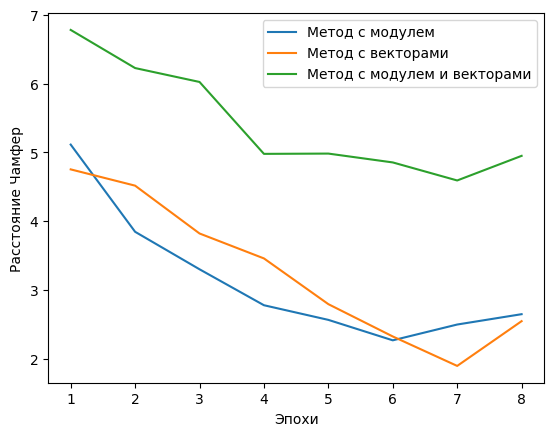

In [22]:
val_chamfer_mag_field = np.load(DIR + 'val_chamfer_mag_and_field.npy')
val_chamfer_field = np.load(DIR +'val_chamfer_field.npy')
val_chamfer_mag = np.load(DIR +'val_chamfer_mag.npy')

# val_chamfer_old = list(val_chamfer_old)
# val_chamfer_old.insert(0, 4)

epochs = range(1, len(val_chamfer_mag_field) + 1)
fig, ax = plt.subplots()

ax.plot(epochs, val_chamfer_mag, label='Метод с модулем')
ax.plot(epochs, val_chamfer_field, label='Метод с векторами')
ax.plot(epochs, val_chamfer_mag_field, label='Метод с модулем и векторами')


plt.xlabel('Эпохи')
plt.ylabel('Расстояние Чамфер')
plt.legend()


plt.show()

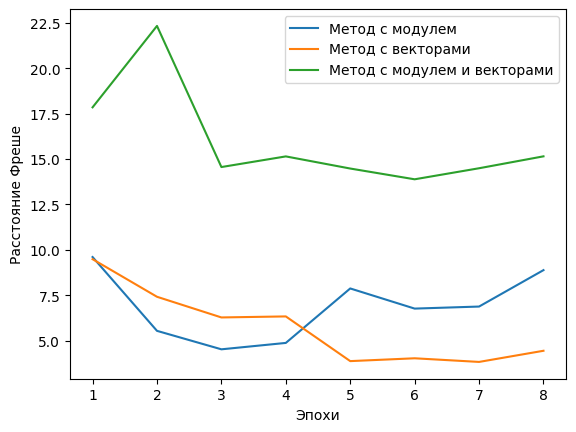

In [24]:
# val_frechet_mag_field = np.load(DIR + 'val_frechet_mag_field.npy')
val_frechet_mag_field = np.load(DIR + 'val_frechet_mag_and_field.npy')
val_frechet_field = np.load(DIR +'val_frechet_field.npy')
val_frechet_mag = np.load(DIR +'val_frechet_mag.npy')

# val_chamfer_old = list(val_chamfer_old)
# val_chamfer_old.insert(0, 4)

epochs = range(1, len(val_frechet_mag_field) + 1)
fig, ax = plt.subplots()

ax.plot(epochs, val_frechet_mag, label='Метод с модулем')
ax.plot(epochs, val_frechet_field, label='Метод с векторами')
ax.plot(epochs, val_frechet_mag_field, label='Метод с модулем и векторами')


plt.xlabel('Эпохи')
plt.ylabel('Расстояние Фреше')
plt.legend()


plt.show()

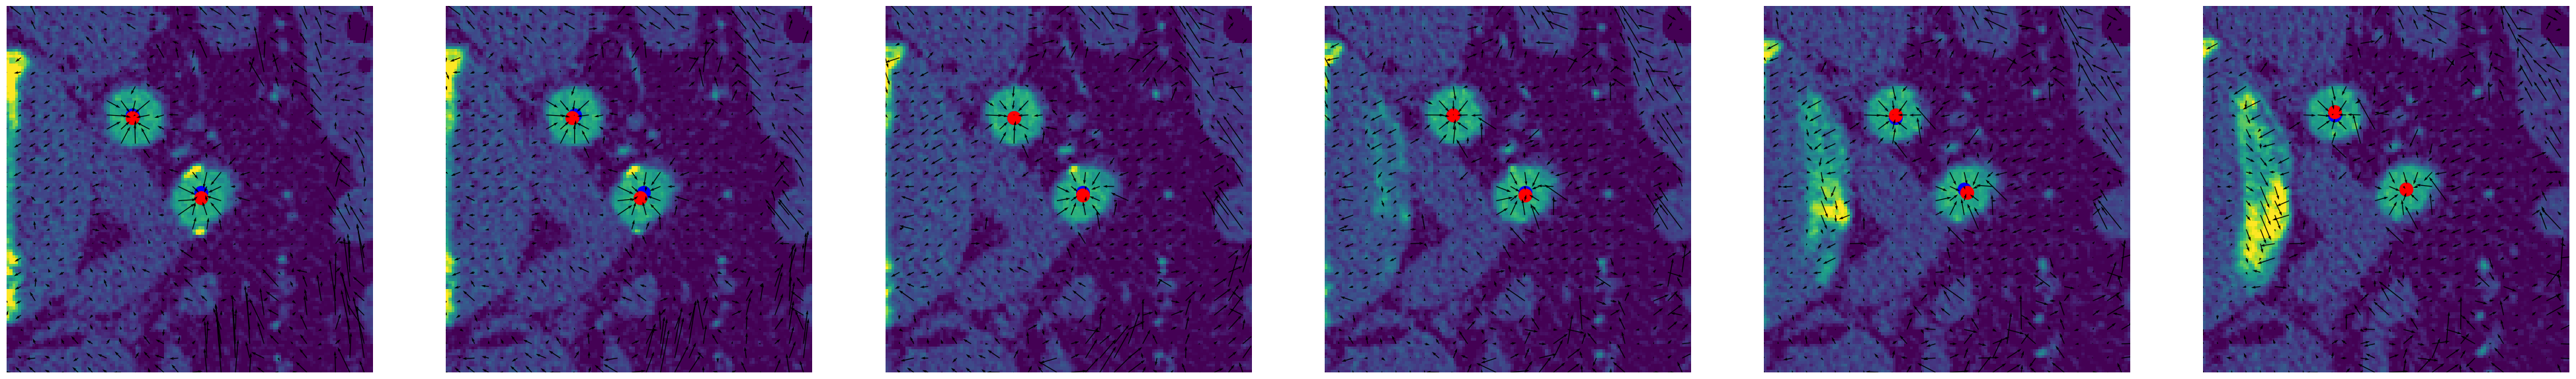

In [6]:
epoch = 6
instance = 0
size = 200

pred_attraction_field = np.load(DIR+ f'/testtraining/save_pred_attractions{epoch}.npz')['data'][instance][:,:,64:192,64:192]
image = np.load(DIR+ f'/testtraining/save_images{epoch}.npz')['data'][instance][:,64:192,64:192]
pred_centerline = np.load(DIR+ f'/testtraining/save_pred_centerlines{epoch}.npz')['data'][instance][:,64:192,64:192]
centerline = np.load(DIR+ f'/testtraining/save_centerlines{epoch}.npz')['data'][instance][:,64:192,64:192]

new_img = []
for slice_ in image:
    slice_ = np.clip(slice_, a_min=-100, a_max=700)
    slice_ = 255 * ((slice_ - slice_.min()) / (slice_.max() - slice_.min()))
    new_img.append(slice_)
new_img = np.array(new_img)

x,y = np.meshgrid(np.arange(0,128 ,5),np.arange(0,128,5))
u=pred_attraction_field[1,0,x,y]; v=pred_attraction_field[2,0,x,y]
plt.figure(figsize=(50,50))
plt.subplot(161)
y_coords, x_coords = np.where(pred_centerline[0] != 0)
plt.scatter(x_coords, y_coords, c='blue', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing

y_coords, x_coords = np.where(centerline[0] != 0)
plt.scatter(x_coords, y_coords, c='red', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing
 
plt.imshow(new_img[0,:,:], extent=[0,128 ,0,128 ],origin='lower')
plt.quiver(y, x, v, u ,angles = 'xy')

plt.axis('off')
u=pred_attraction_field[1,1,x,y]; v=pred_attraction_field[2,1,x,y]

plt.subplot(162)
y_coords, x_coords = np.where(pred_centerline[1] != 0)
plt.scatter(x_coords, y_coords, c='blue', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing

y_coords, x_coords = np.where(centerline[1] != 0)
plt.scatter(x_coords, y_coords, c='red', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing
 
plt.imshow(new_img[1,:,:], extent=[0,128 ,0,128 ],origin='lower')
plt.quiver(y, x, v, u ,angles = 'xy')

plt.axis('off')
u=pred_attraction_field[1,2,x,y]; v=pred_attraction_field[2,2,x,y]

plt.subplot(163)
y_coords, x_coords = np.where(pred_centerline[2] != 0)
plt.scatter(x_coords, y_coords, c='blue', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing

y_coords, x_coords = np.where(centerline[2] != 0)
plt.scatter(x_coords, y_coords, c='red', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing
 
plt.imshow(new_img[2,:,:], extent=[0,128 ,0,128 ],origin='lower')
plt.quiver(y, x, v, u ,angles = 'xy')
plt.axis('off')
u=pred_attraction_field[1,3,x,y]; v=pred_attraction_field[2,3,x,y]

plt.subplot(164)
y_coords, x_coords = np.where(pred_centerline[3] != 0)
plt.scatter(x_coords, y_coords, c='blue', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing

y_coords, x_coords = np.where(centerline[3] != 0)
plt.scatter(x_coords, y_coords, c='red', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing
 
plt.imshow(new_img[3,:,:], extent=[0,128 ,0,128 ],origin='lower')
plt.quiver(y, x, v, u ,angles = 'xy')

plt.axis('off')
u=pred_attraction_field[1,4,x,y]; v=pred_attraction_field[2,4,x,y]

plt.subplot(165)
y_coords, x_coords = np.where(pred_centerline[4] != 0)
plt.scatter(x_coords, y_coords, c='blue', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing

y_coords, x_coords = np.where(centerline[4] != 0)
plt.scatter(x_coords, y_coords, c='red', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing
 
plt.imshow(new_img[4,:,:], extent=[0,128 ,0,128 ],origin='lower')
plt.quiver(y, x, v, u ,angles = 'xy')

plt.axis('off')
u=pred_attraction_field[1,5,x,y]; v=pred_attraction_field[2,5,x,y]
plt.subplot(166)
y_coords, x_coords = np.where(pred_centerline[5] != 0)
plt.scatter(x_coords, y_coords, c='blue', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing

y_coords, x_coords = np.where(centerline[5] != 0)
plt.scatter(x_coords, y_coords, c='red', s=size)  # Scatter plot of points
plt.gca().invert_yaxis()  # Invert y-axis to match array indexing
 
plt.imshow(new_img[5,:,:], extent=[0,128 ,0,128 ],origin='lower')
plt.quiver(y, x, v, u ,angles = 'xy')
plt.axis('off')
# print(pred_centerline)
plt.show()

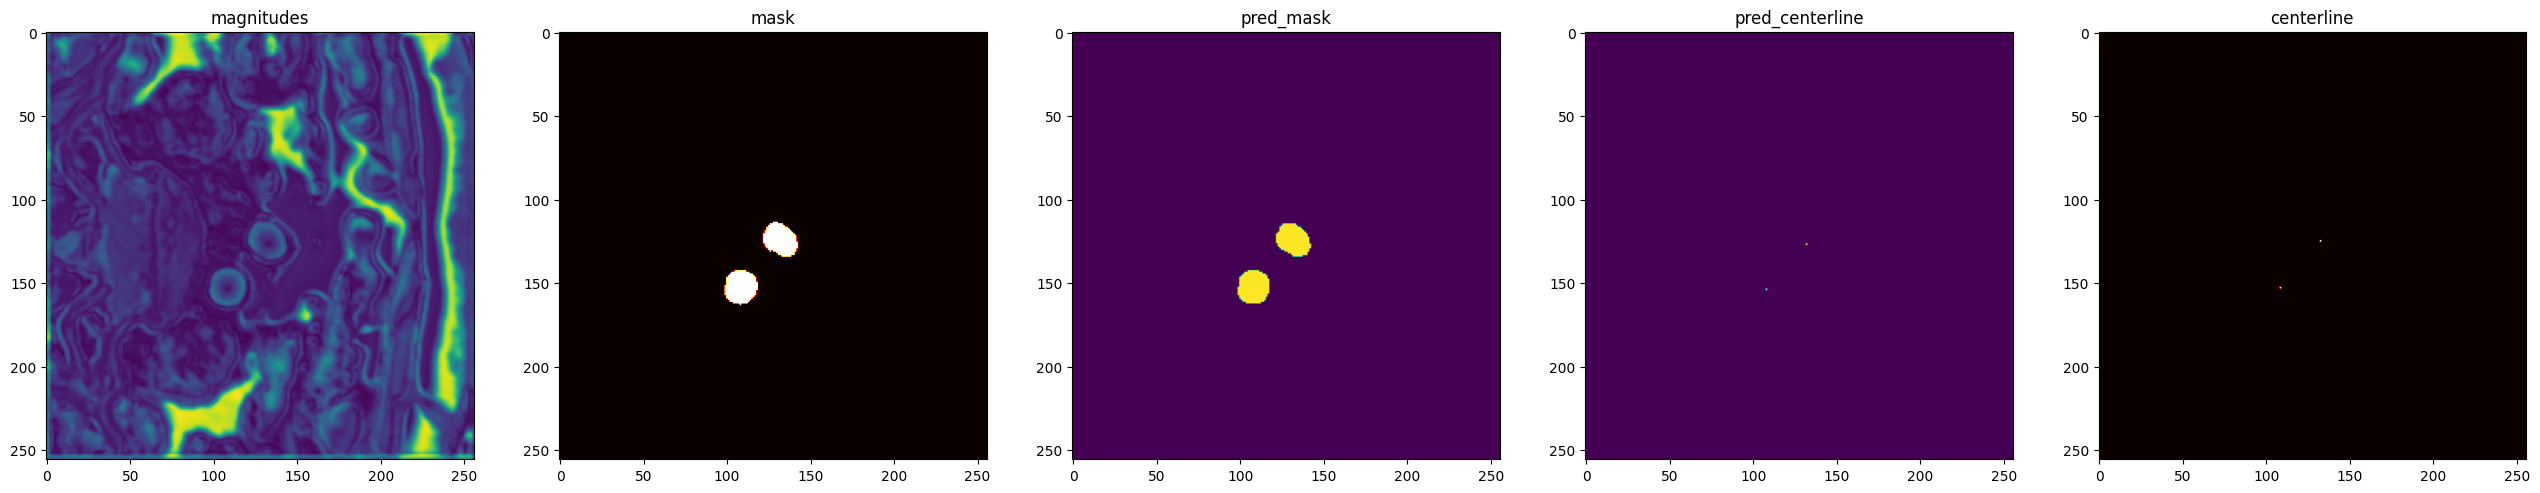

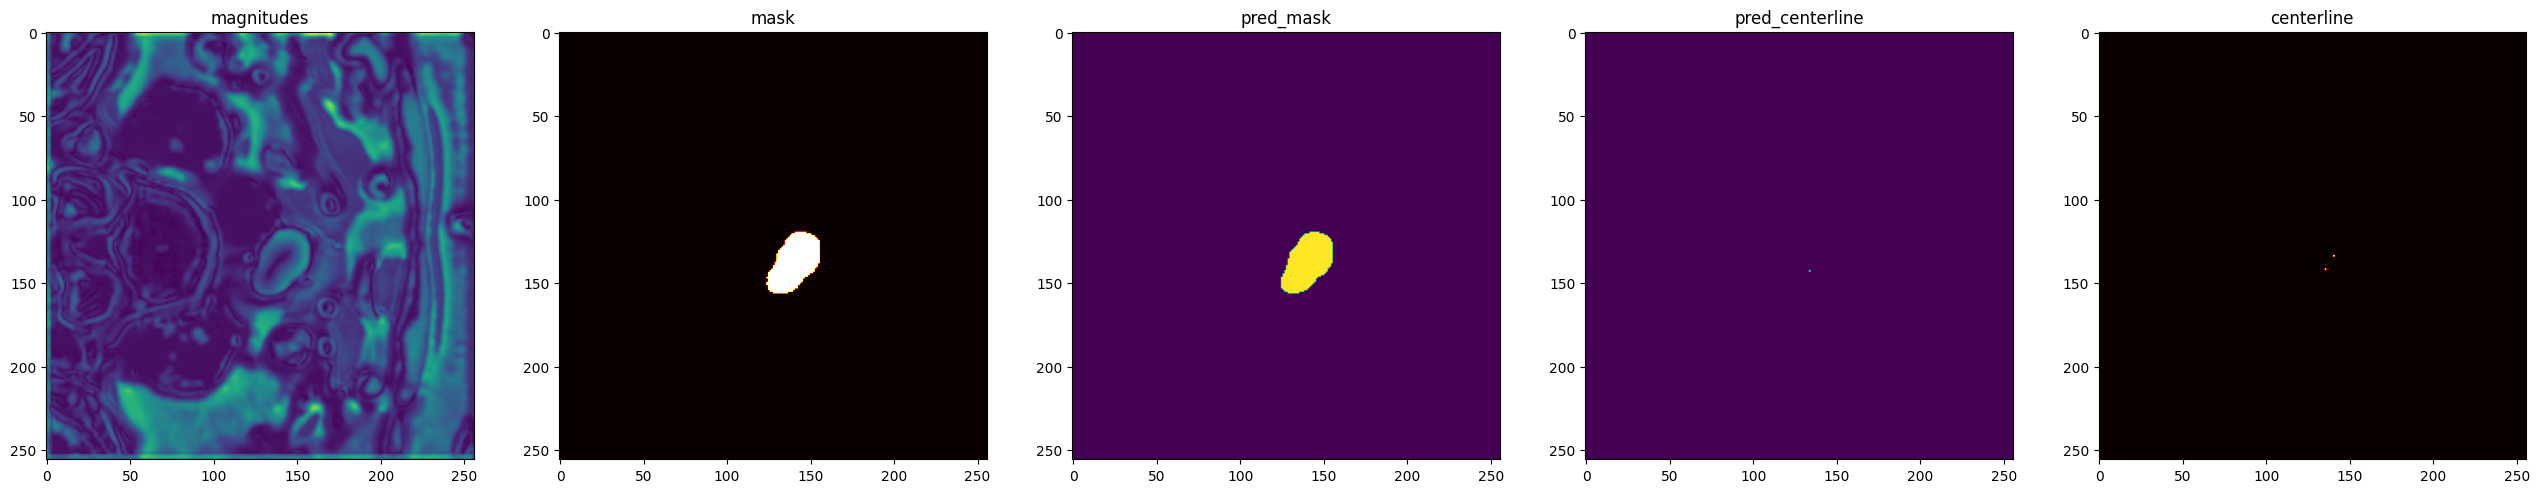

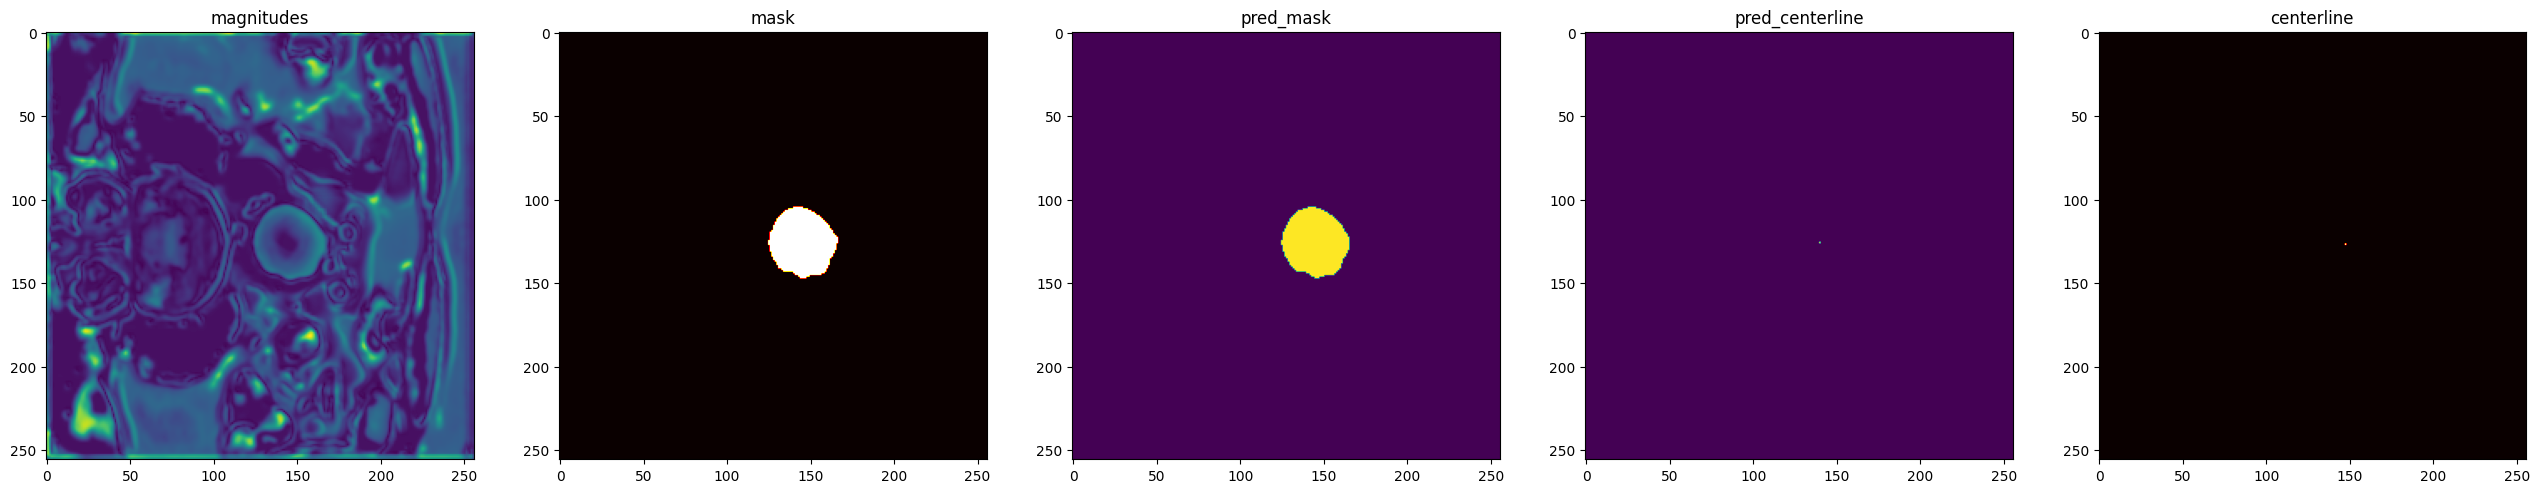

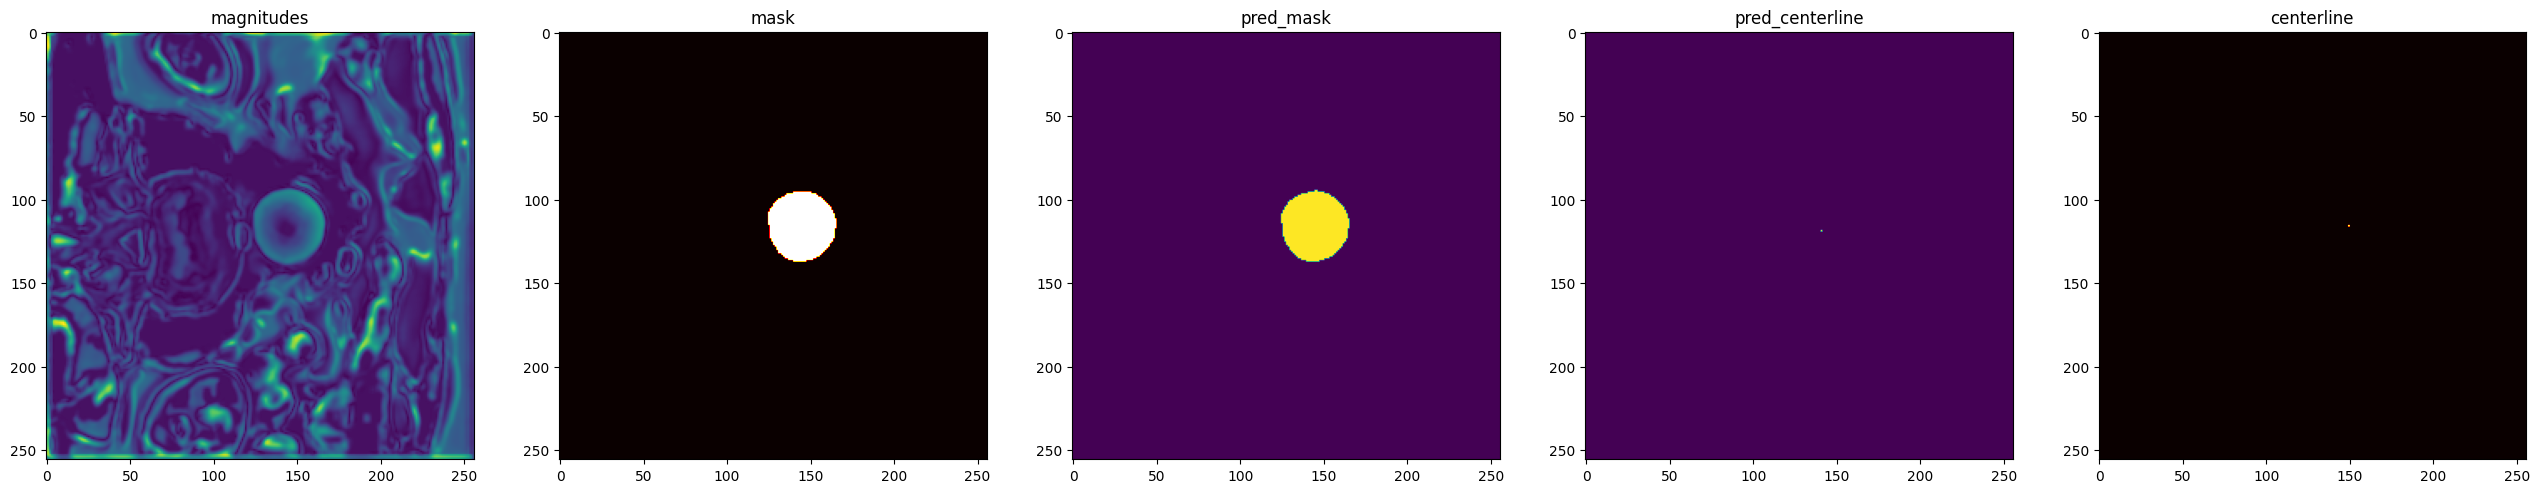

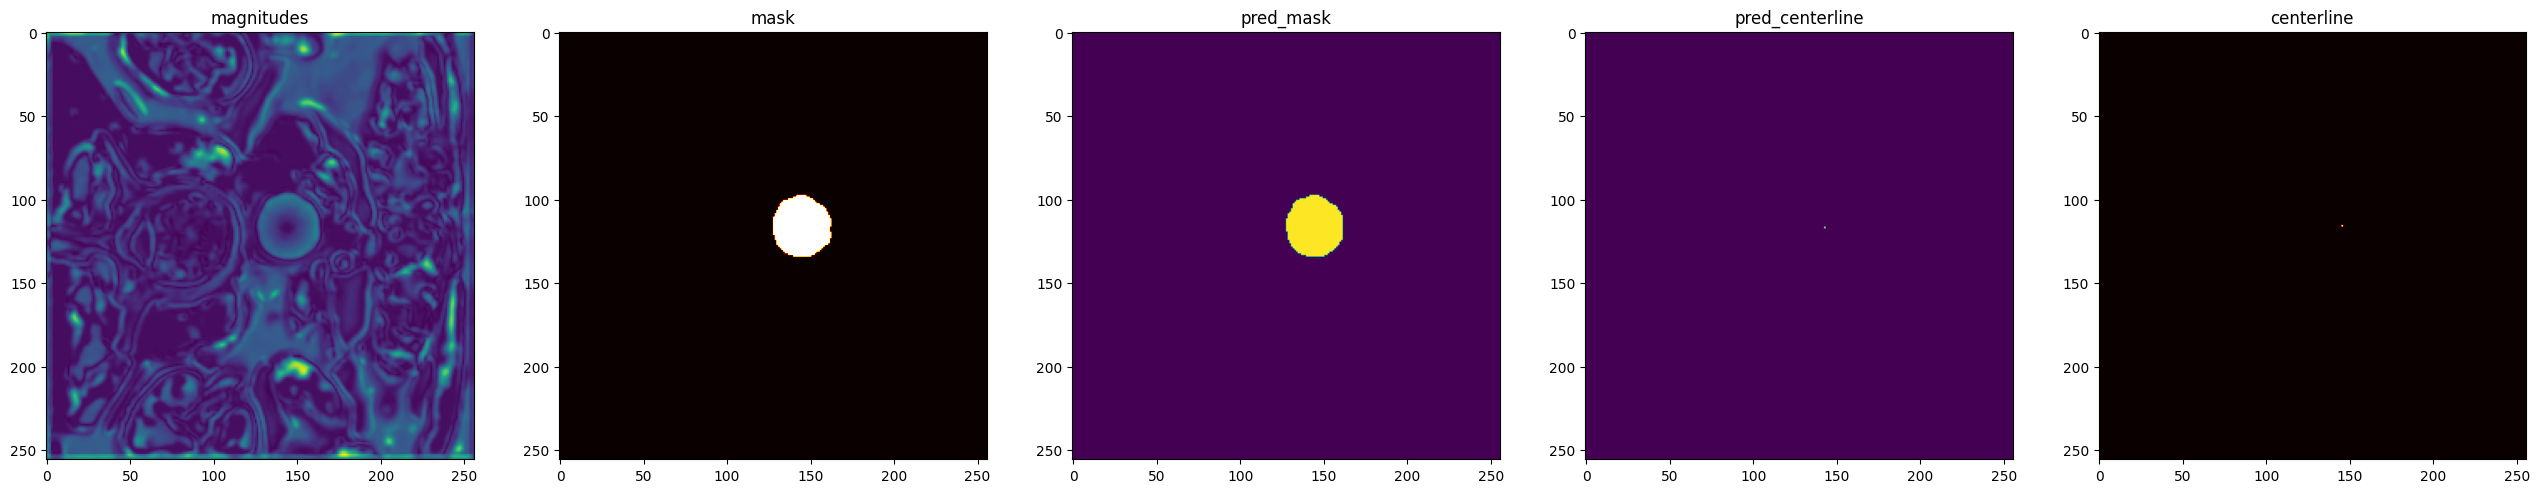

In [9]:
epoch = 6
instance = 0

pred_attraction_field = np.moveaxis(np.load(DIR+ f'/testtraining/save_pred_attractions{epoch}.npz')['data'][instance],0,-1)
magnitudes = []
for i, layer in enumerate(pred_attraction_field):
            layer_reshaped = layer.reshape(-1,3)
            magnitude = np.linalg.norm(layer_reshaped, axis=1)
            magnitude = magnitude.reshape(256, 256)
            magnitudes.append(magnitude)
magnitudes = np.array(magnitudes)
mask = np.load(DIR+ f'/testtraining/save_masks{epoch}.npz')['data'][instance][:,:,:,1]
pred_mask = np.load(DIR+ f'/testtraining/save_pred_masks{epoch}.npz')['data'][instance].argmax(axis =0)
image = np.load(DIR+ f'/testtraining/save_images{epoch}.npz')['data'][instance]
pred_centerline = np.load(DIR+ f'/testtraining/save_pred_centerlines{epoch}.npz')['data'][instance]
centerline = np.load(DIR+ f'/testtraining/save_centerlines{epoch}.npz')['data'][instance]
new_img = []
for slice_ in image:
    slice_ = np.clip(slice_, a_min=-100, a_max=700)

    slice_ = 255 * ((slice_ - slice_.min()) / (slice_.max() - slice_.min()))
    new_img.append(slice_)
new_img = np.array(new_img)


for j in range(0, 130, 30):
    plt.figure(figsize=(32,18))
    plt.subplot(151)
    plt.imshow(100*magnitudes[j,:,:])
    plt.title('magnitudes')

    plt.subplot(152)
    plt.imshow(mask[j,:,:], cmap='hot')
    plt.title('mask')

    plt.subplot(153)
    plt.imshow(pred_mask[j,:,:])
    plt.title('pred_mask')

    plt.subplot(154)
    plt.imshow(pred_centerline[j,:,:])
    plt.title('pred_centerline')

    plt.subplot(155)
    plt.imshow(centerline[j,:,:], cmap='hot')
    plt.title('centerline')

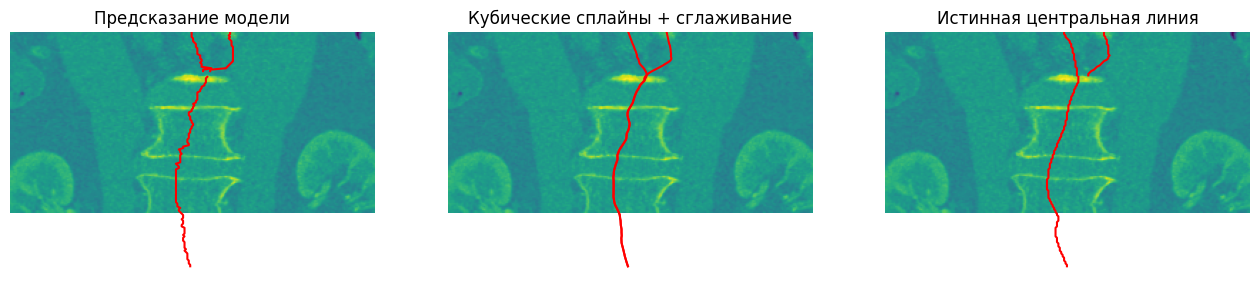

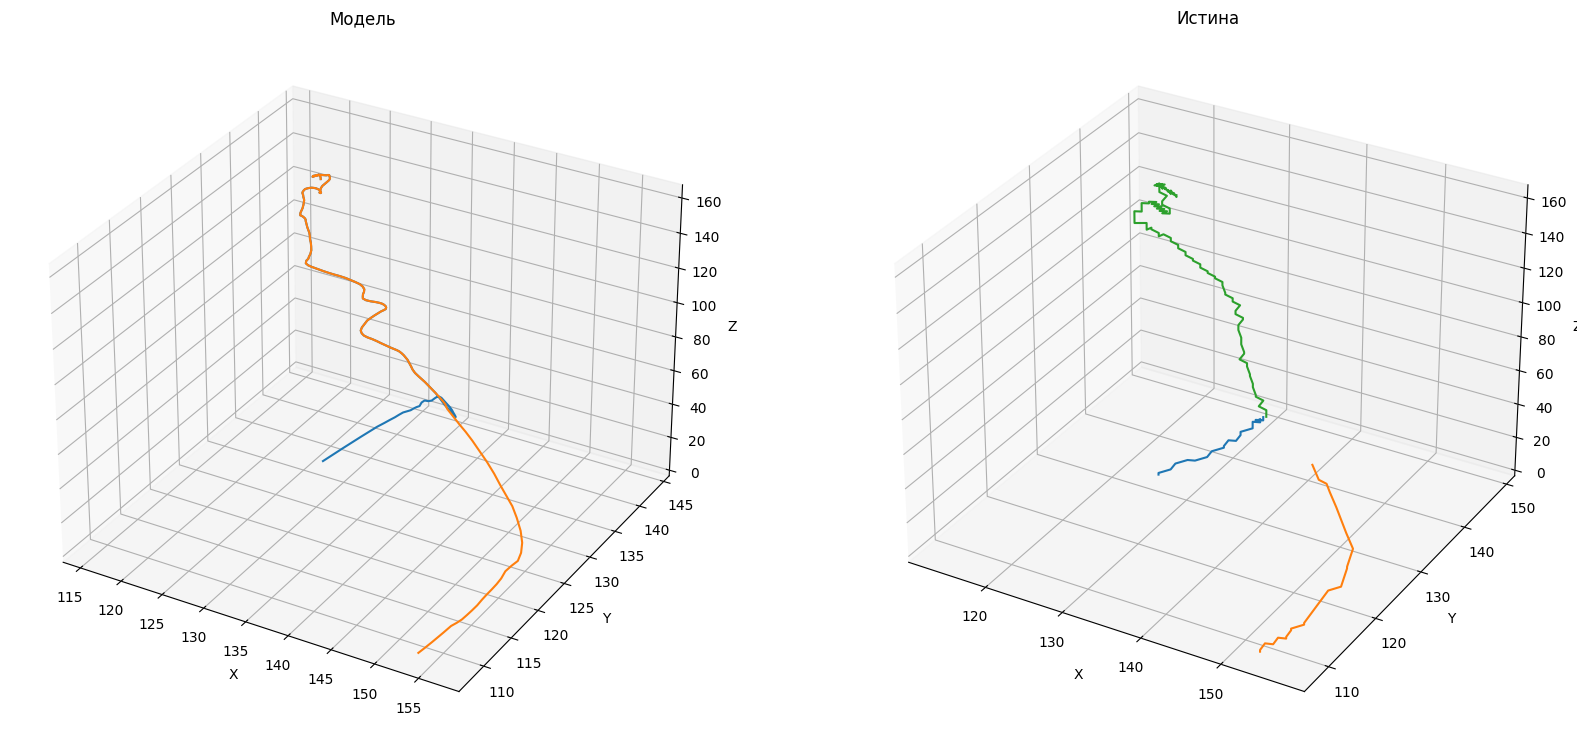

chamfer 2.1537720034878323
frechet 5.523718489530789


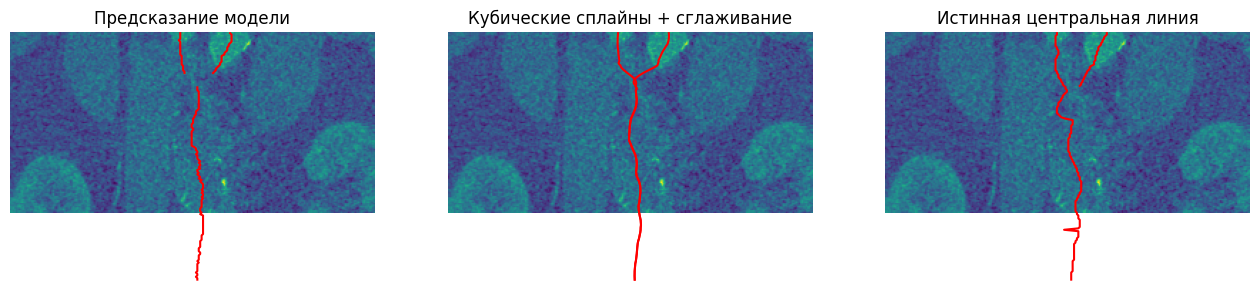

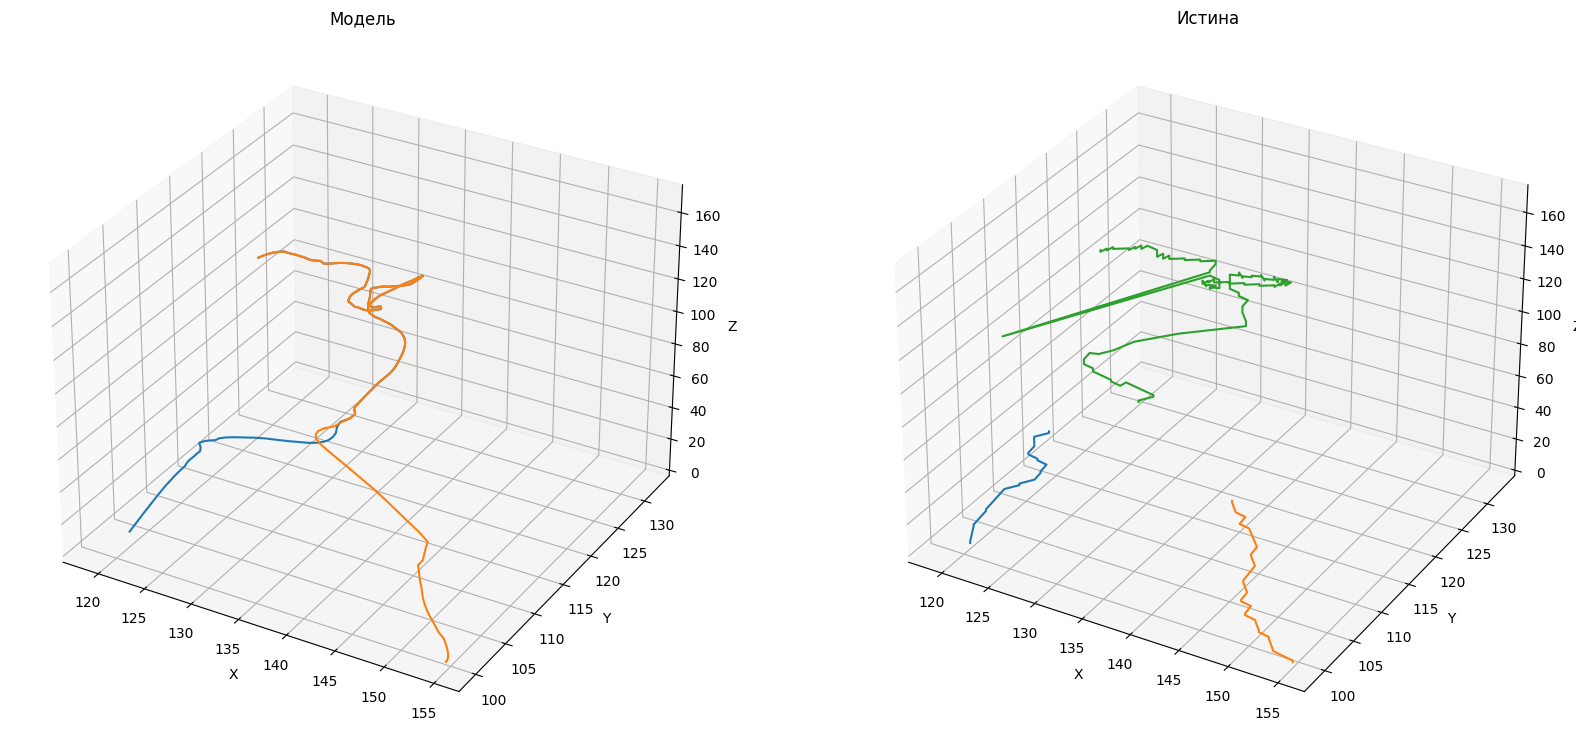

chamfer 2.438044793682743
frechet 5.2722179421306565


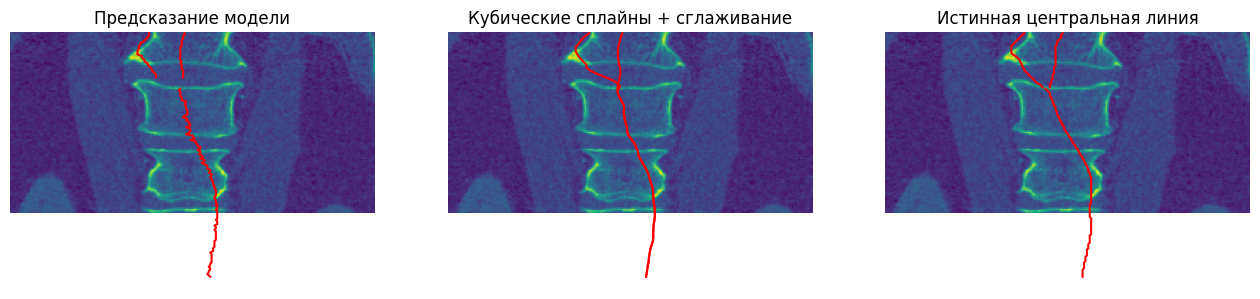

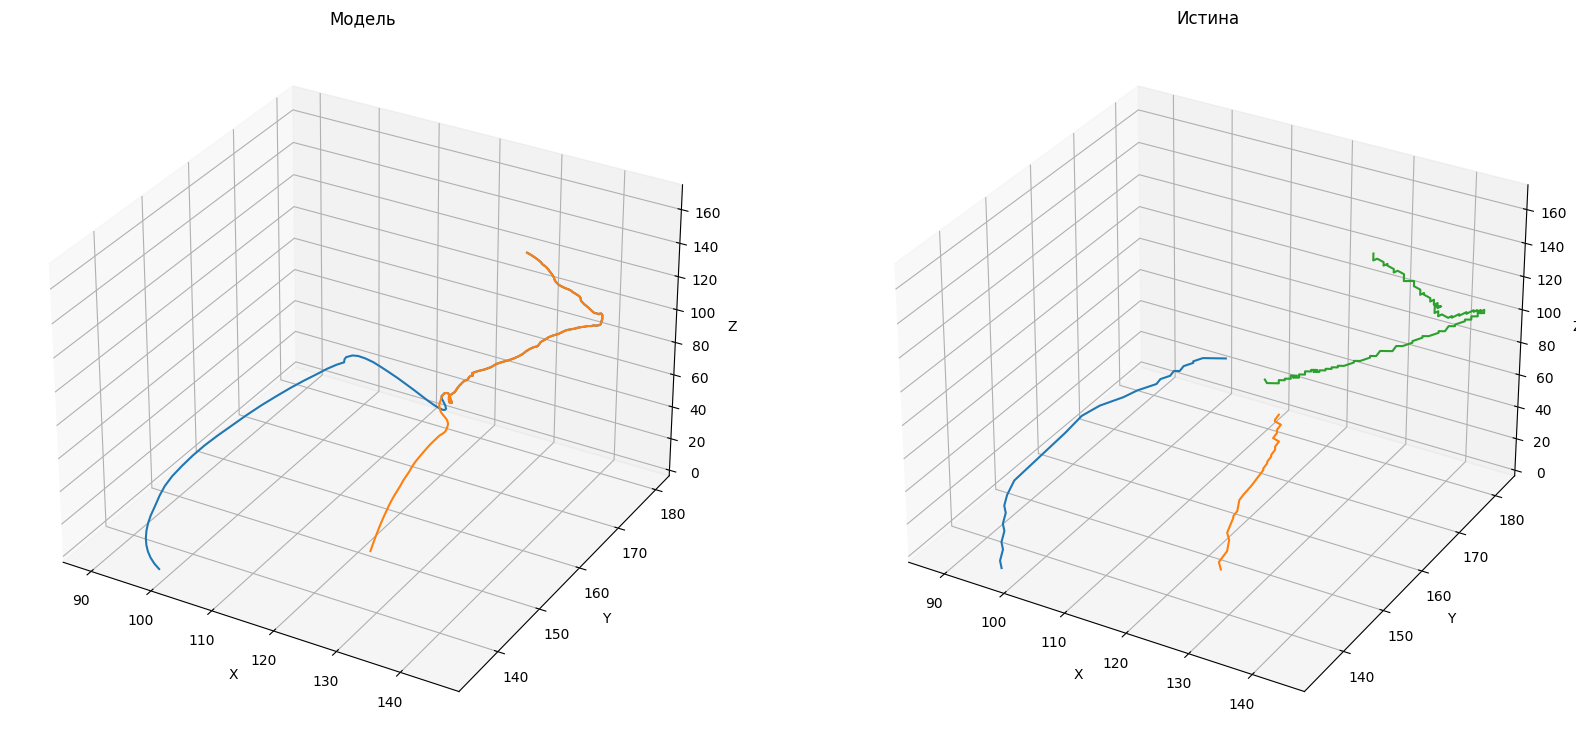

chamfer 2.4245233135127484
frechet 4.333333333333333
Фреше общее 5.043089921664926
Чамфер общее 2.338780036894441
Фреше биффуркация 3.8498365855987977
Чамфер биффуркация 1.7015093676331094
Фреше одиночная 7.429596593797183
Чамфер одиночная 3.613321375417106


In [18]:
chamfer = []
chamfer_bif = []
chamfer_single = []
frechet = []
frechet_bif = []
frechet_single = []
epoch = 6
instances = 3
for instance in range(instances):
        bif_arr = np.load(DIR+ f'testarrays/bif_arr{epoch}_{instance}.npz')['data']
        pred_bif_arr = np.load(DIR+ f'testarrays/pred_bif_arr{epoch}_{instance}.npz')['data']
        single_arr = np.load(DIR+ f'testarrays/single_arr{epoch}_{instance}.npz')['data']
        pred_single_arr = np.load(DIR+ f'testarrays/pred_single_arr{epoch}_{instance}.npz')['data']
        image =np.load(DIR+ f'/testtraining/save_images{epoch}.npz')['data'][instance][:,:,100]
        left_bif, right_bif = divide(bif_arr)
        plt.figure(figsize=(16, 16))
        plt.subplot(133)
        plt.imshow(image)
        plt.axis('off')  
        plt.plot(single_arr[:,1], single_arr[:,0], color='red')
        plt.plot(left_bif[:,1], left_bif[:,0], color='red')
        plt.plot(right_bif[:,1], right_bif[:,0], color='red')
        plt.title('Истинная центральная линия')
        pred_left_bif, pred_right_bif = divide(pred_bif_arr)
        window_size = 20
        single_arr = np.array(single_arr)
        try:
            z_points_left = np.concatenate((pred_left_bif[:,0], pred_single_arr[:,0]))
            y_points_left= np.concatenate((pred_left_bif[:,2], pred_single_arr[:,2]))

            spline_interp = interp1d(z_points_left, y_points_left, kind='cubic')

            z_interp_left = np.linspace(min(z_points_left), max(z_points_left), 200)
            y_interp_left = spline_interp(z_interp_left)
            interp_sm_leftzy = smooth(np.stack((z_interp_left, y_interp_left), axis = 1), window_size)

            z_points_right = np.concatenate((pred_right_bif[:,0], pred_single_arr[:,0]))
            y_points_right= np.concatenate((pred_right_bif[:,2], pred_single_arr[:,2]))

            spline_interp = interp1d(z_points_right, y_points_right, kind='cubic')

            z_interp_right= np.linspace(min(z_points_right), max(z_points_right), 200)
            y_interp_right = spline_interp(z_interp_right)
            interp_sm_rightzy= smooth(np.stack((z_interp_right, y_interp_right), axis = 1), window_size)
            
            x_points_left= np.concatenate((pred_left_bif[:,1], pred_single_arr[:,1]))

            spline_interp = interp1d(z_points_left, x_points_left, kind='cubic')

            x_interp_left = spline_interp(z_interp_left)
            interp_sm_leftzx = smooth(np.stack((z_interp_left, x_interp_left), axis = 1), window_size)

            x_points_right= np.concatenate((pred_right_bif[:,1], pred_single_arr[:,1]))

            spline_interp = interp1d(z_points_right, x_points_right, kind='cubic')

            x_interp_right = spline_interp(z_interp_right)
            interp_sm_rightzx= smooth(np.stack((z_interp_right, x_interp_right), axis = 1), window_size)
            interp_left = []
            interp_right = []
            for i, arr in enumerate(interp_sm_leftzx):
                interp_left.append([arr[0],arr[1], interp_sm_leftzy[i,1]] )
            for i, arr in enumerate(interp_sm_rightzx):
                interp_right.append([arr[0],arr[1], interp_sm_rightzy[i,1]] )
            interp_left = np.array(interp_left)
            interp_right = np.array(interp_right)
        except Exception as e:
                    print(str(e))


        if len(pred_single_arr) > len(single_arr):
            pred_single_arr = pred_single_arr[len(pred_single_arr) - len(single_arr):]
        else:
            pred_single_arr = pred_single_arr[len(single_arr) - len(pred_single_arr):]
     
        try:
            new_bif_arr = []
            for arr in bif_arr:
                if arr[0] <= np.max(pred_bif_arr[:,0]):
                    new_bif_arr.append(arr)
            left_bif, right_bif = divide(new_bif_arr)
        except Exception as e:
            print(str(e))
            continue


        try:
            spline_interp_left_bif = interp1d(pred_left_bif[:,0], pred_left_bif[:,2], kind='cubic')
            z_interp_left_bif = np.linspace(min(pred_left_bif[:,0]), max(pred_left_bif[:,0]), len(left_bif))
            y_interp_left_bif = spline_interp_left_bif(z_interp_left_bif)
            interp_sm_left_bifzy = smooth(np.stack((z_interp_left_bif, y_interp_left_bif), axis = 1), window_size)

            spline_interp_right_bif = interp1d(pred_right_bif[:,0], pred_right_bif[:,2], kind='cubic')
            z_interp_right_bif = np.linspace(min(pred_right_bif[:,0]), max(pred_right_bif[:,0]), len(right_bif))
            y_interp_right_bif = spline_interp_right_bif(z_interp_right_bif)
            interp_sm_right_bifzy = smooth(np.stack((z_interp_right_bif, y_interp_right_bif), axis = 1), window_size)

            spline_interp_single = interp1d(pred_single_arr[:,0], pred_single_arr[:,2], kind='cubic')
            z_interp_single= np.linspace(min(pred_single_arr[:,0]), max(pred_single_arr[:,0]), len(single_arr))
            y_interp_single = spline_interp_single(z_interp_single)
            interp_sm_singlezy = smooth(np.stack((z_interp_single, y_interp_single), axis = 1), window_size)

            spline_interp_left_bif = interp1d(pred_left_bif[:,0], pred_left_bif[:,1], kind='cubic')
            z_interp_left_bif = np.linspace(min(pred_left_bif[:,0]), max(pred_left_bif[:,0]), len(left_bif))
            x_interp_left_bif = spline_interp_left_bif(z_interp_left_bif)
            interp_sm_left_bifzx = smooth(np.stack((z_interp_left_bif, x_interp_left_bif), axis = 1), window_size)

            spline_interp_right_bif = interp1d(pred_right_bif[:,0], pred_right_bif[:,1], kind='cubic')
            z_interp_right_bif = np.linspace(min(pred_right_bif[:,0]), max(pred_right_bif[:,0]), len(right_bif))
            x_interp_right_bif = spline_interp_right_bif(z_interp_right_bif)
            interp_sm_right_bifzx = smooth(np.stack((z_interp_right_bif, x_interp_right_bif), axis = 1), window_size)

            spline_interp_single = interp1d(pred_single_arr[:,0], pred_single_arr[:,1], kind='cubic')
            z_interp_single= np.linspace(min(pred_single_arr[:,0]), max(pred_single_arr[:,0]), len(single_arr))
            x_interp_single = spline_interp_single(z_interp_single)
            interp_sm_singlezx = smooth(np.stack((z_interp_single, x_interp_single), axis = 1), window_size)

            final_left_bif = []
            final_right_bif = []
            final_single = []

            for i, arr in enumerate(interp_sm_left_bifzx):
                final_left_bif.append([arr[0],arr[1], interp_sm_left_bifzy[i,1]])
            for i, arr in enumerate(interp_sm_right_bifzx):
                final_right_bif.append([arr[0],arr[1], interp_sm_right_bifzy[i,1]])
            for i, arr in enumerate(interp_sm_singlezx):
                final_single.append([arr[0],arr[1], interp_sm_singlezy[i,1]])
        except Exception as e:
            print(str(e))

        plt.subplot(131)
        plt.imshow(image)
        plt.axis('off')
        plt.plot(pred_single_arr[:,1], pred_single_arr[:,0], color='red')
        plt.plot(pred_left_bif[:,1], pred_left_bif[:,0], color='red')
        plt.plot(pred_right_bif[:,1], pred_right_bif[:,0], color='red')
        plt.title('Предсказание модели')

        # plt.subplot(142)
        # plt.imshow(image)
        # plt.plot(interp_sm_left_bifzx[:,1], interp_sm_left_bifzx[:,0], color='red')
        # plt.plot(interp_sm_right_bifzx[:,1], interp_sm_right_bifzx[:,0], color='red')
        # plt.plot(interp_sm_singlezx[:,1], interp_sm_singlezx[:,0], color='red')
        # plt.title('Для подсчёта метрик')
        # plt.axis('off')
        # plt.show()

        plt.subplot(132)
        plt.imshow(image)
        plt.plot(interp_sm_leftzx[:,1], interp_sm_leftzx[:,0], color='red')
        plt.plot(interp_sm_rightzx[:,1], interp_sm_rightzx[:,0], color='red')
        plt.title('Кубические сплайны + сглаживание')
        plt.axis('off')
        plt.show()

        fig = plt.figure(figsize = (20,20))
        ax = fig.add_subplot(121, projection='3d')

        ax.plot(interp_left[:,1], interp_left[:,2], interp_left[:,0])
        ax.plot(interp_right[:,1], interp_right[:,2], interp_right[:,0])

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Модель')

        ax = fig.add_subplot(122, projection='3d')
        ax.plot(left_bif[:,1], left_bif[:,2], left_bif[:,0])
        ax.plot(right_bif[:,1], right_bif[:,2], right_bif[:,0])
        ax.plot(single_arr[:,1], single_arr[:,2], single_arr[:,0])

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Истина')

        plt.show()

        #сглаживание
        # frechet_dist_left_bif = linear_frechet(left_bif[:,:2], pred_left_bif_smoothed, euclidean)
        # frechet_dist_right_bif = linear_frechet(right_bif[:,:2], pred_right_bif_smoothed, euclidean)
        # frechet_dist_single = linear_frechet(single_arr[:,:2], pred_single_arr_smoothed, euclidean)
        try:
            frechet_dist_left_bif = linear_frechet(left_bif[:,:2], pred_left_bif[:,:2], euclidean)
            frechet_dist_right_bif = linear_frechet(right_bif[:,:2], pred_right_bif[:,:2], euclidean)
            frechet_dist_single = linear_frechet(single_arr[:,:2], pred_single_arr[:,:2], euclidean)

            chamfer_dist_left_bif = chamfer_distance(left_bif, pred_left_bif)
            chamfer_dist_right_bif = chamfer_distance(right_bif, pred_right_bif)
            chamfer_dist_single = chamfer_distance(single_arr, pred_single_arr)
        except Exception as e:
            print(str(e))
            continue        
        # куб сплайны и сглаживание
        # frechet_dist_left_bif = linear_frechet(left_bif[:,:2], interp_sm_left_bifzx, euclidean)
        # frechet_dist_right_bif = linear_frechet(right_bif[:,:2], interp_sm_right_bifzx, euclidean)
        # frechet_dist_single = linear_frechet(single_arr[:,:2], interp_sm_singlezx, euclidean)

        # chamfer_dist_left_bif = chamfer_distance(left_bif, final_left_bif)
        # chamfer_dist_right_bif = chamfer_distance(right_bif, final_right_bif)
        # chamfer_dist_single = chamfer_distance(single_arr, final_single)

        print('chamfer', np.mean([chamfer_dist_left_bif, chamfer_dist_right_bif, chamfer_dist_single]))
        print('frechet', np.mean([frechet_dist_left_bif, frechet_dist_right_bif, frechet_dist_single]))
        chamfer.append(np.mean([chamfer_dist_left_bif, chamfer_dist_right_bif, chamfer_dist_single]))
        frechet.append(np.mean([frechet_dist_left_bif, frechet_dist_right_bif, frechet_dist_single]))

        chamfer_bif.append(np.mean([chamfer_dist_left_bif, chamfer_dist_right_bif]))
        frechet_bif.append(np.mean([frechet_dist_left_bif, frechet_dist_right_bif]))

        chamfer_single.append(chamfer_dist_single)
        frechet_single.append(frechet_dist_single)

print("Фреше общее",np.mean(frechet))
print("Чамфер общее", np.mean(chamfer))
      
print("Фреше биффуркация",np.mean(frechet_bif))
print("Чамфер биффуркация", np.mean(chamfer_bif))
            
print("Фреше одиночная", np.mean(frechet_single))
print("Чамфер одиночная",np.mean(chamfer_single))